<a href="https://colab.research.google.com/github/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/blob/main/Tax_Cuts_on_the_Economy_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Impact of Corporate Tax Cuts on Employment, Wages, Investment, and Output

Ting Guo (25319997)
Jiayi Wu (49193634)

## Setup

Data source: all raw data are downloaded from [Statistics Canada](https://www150.statcan.gc.ca/n1/en/type/data?MM=1) and saved to [this](https://github.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec) GitHub project in the `raw_data` folder.

In particular, we use the following databases on Statistics Canada:


*   Employment data: [Employment and average weekly earnings (including overtime) for all employees by province and territory, monthly, seasonally adjusted](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410022301)
*   Wages data: [Employee wages by industry, annual](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410006401)
*   Investment data: [Flows and stocks of fixed non-residential capital, by industry and type of asset, Canada, provinces and territories](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610009601)
*   Output data: [Output, by sector and industry, provincial and territorial](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610048801)

In [ ]:
# import libararies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

Equation (1): 
$ y_{spt} = \sum_{\tau = 2011}^{2017} \theta_\tau {1}(t=\tau) \times M_s \times Q_p + \sum_{\tau = 2011}^{2017}  \beta_\tau {1}(t=\tau) \times M_s + \sum_{\tau = 2011}^{2017}  \gamma_\tau {1}(t=\tau) \times Q_p + \alpha_s + \alpha_p + u_{spt} $

Equation (2): $Y_{spt} =  \theta P_t \times M_s \times Q_p + \beta P_t \times M_s + \gamma P_t \times Q_p + \alpha_s + \alpha_p + \alpha_t + \epsilon_{spt}$

## Functions
We design several functions to help reduce the repetitive work that is performed to every raw dataset, including cleaning raw data, getting the validation coefficients, and plotting validation coeficients.

In [ ]:
# a function that performs data cleaning to df, a Pandas dataframe with uncleaned data
# the data type of the variable col is changed to int if num_decimals == 0, 
#     or float (round to num_decimals if num_decimals > 0)
def clean_data(df, col, num_decimals):
  # fill all missing values based on the most previously available value of the column
  # eg: in the raw data, many rows under variables province and sector are empty 
  #     - we fill these cells with the value the most previously non-empty cell
  df = df.fillna(method='ffill')

  # change the data type of the column year to int
  df['year'] = df['year'].astype(np.float32).astype(int)

  # create copies of the column year, call them theta_year, beta_year and gamma_year
  # to calculate the coefficients in the validation model (see Equation (1))
  df['theta_year'] = df['year']
  df['beta_year'] = df['year']
  df['gamma_year'] = df['year']
  
  # change the data type of the input column col to int or float based on num_decimals
  df[col] = df[col].replace({',': ''}, regex=True)
  df[col] = df[col].astype(np.float32)
  if num_decimals == 0:
    df[col] = df[col].astype(int)
  else:
    df[col] = df[col].round(num_decimals)

  # get the log value of column col
  log_var = 'log_' + col
  df[log_var] = np.log(df[col])
  
  # generate dummy variables for province, sector and year variables
  # is_quebec = 1 if it is in Quebec, 0 otherwise
  # is_manu = 1 if it is in manufacturing sector, 0 otherwise
  # is_after_reform = 1 if the year is >= 2014, 0 otherwise
  df['is_quebec'] = (df['province'] == 'Quebec')
  df['is_manu'] = (df['sector'] == 'Manufacturing')
  df['is_after_reform'] = (df['year'] >= 2014)
  df = df.astype({'is_quebec': int, 'is_manu': int, 'is_after_reform': int})

  # generate province-and-sector dummy variable is_manu_quebec, 
  # where it is 1 if it is both manufacturing and in Quebec, 0 otherwise
  df['is_manu_quebec'] = df['is_manu'] * df['is_quebec']

  # generate variable province_sector which joins province and sector together
  # df['province_sector'] = df.apply(lambda x: ' & '.join([x['province'], x['sector']]), axis=1)

  return df

In [ ]:
# get the table of coefficients theta_tau's in Equation (1) based on df, the summary table of regression
def validation_coef(summary):
  df_coef = pd.read_html(summary.tables[1].as_html(), header=0)[0]
  df_coef = df_coef.iloc[1:8]
  df_coef = df_coef.rename(columns={'Unnamed: 0': 'year'})
  df_coef['year'] = df_coef['year'].str[14:18]
  df_coef['year'] = df_coef['year'].astype(float).astype(int)

  # calculate coef_norm, normalized coefficients, where the 2013 coefficient is normalized to 0
  df_coef['coef_norm'] = df_coef['coef'] - float(df_coef['coef'].loc[df_coef['year'] == 2013])

  # get difference between coefficient and 2.5% confidence interval 
  # and difference between coefficient and 97.5% confidence interval
  # to be plotted as error bar in the triple difference validation graph (as shown in Equation (1))
  df_coef['loerr'] = df_coef['coef'] - df_coef['[0.025']
  df_coef['uperr'] = df_coef['0.975]'] - df_coef['coef']

  return df_coef

In [ ]:
# a function that plots the coefficients of each year in parallel trend validation, as shown in Equation (1)
def plot_graph(df):
  plt.figure(figsize=(8,4))

  # plot horizontal reference line y = 0 and time-series reference line x = 2013.5
  plt.axhline(0, color='black')
  plt.axvline(2013.5, color='red')
  
  # plot line graph of coefficients for each year and error bars,
  # where error bars represent the 2.5% confidence interval to 97.5% confidence interval range
  plt.errorbar(x=df['year'], y=df['coef_norm'], 
              yerr=np.array(df[['loerr','uperr']].T), 
              fmt='-o', capsize=5)
  plt.xlabel('Year')
  plt.ylabel('Coefficient Estimates [2013=0]')
  plt.show()

## Employment Data

In [ ]:
# get raw employment data URL from github repository
emp_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/employment.csv'

# load employment data to a dataframe (top and bottom meaningless rows are removed)
df_emp_monthly = pd.read_csv(emp_url, skiprows=11, skipfooter=18, header=None, engine='python')
df_emp_monthly = df_emp_monthly.rename(columns={0: 'province', 1: 'sector', 2: 'monthyear', 3: 'employment'})

In [ ]:
# extract year value from monthyear
df_emp_monthly['year'] = df_emp_monthly['monthyear'].str[-4:]

# clean data using pre-defined clean_data() function
df_emp_monthly = clean_data(df_emp_monthly, 'employment', 0)

In [ ]:
# Since the employment is monthly data, for each sector and province combination, calculate its mean employment over each year
# to get an estimate of the acutal annual employment per sector-province combination
df_emp = df_emp_monthly.groupby(['year', 'theta_year', 'beta_year', 'gamma_year', 
                                 'province', 'sector', 'is_quebec', 'is_manu', 
                                 'is_manu_quebec', 'is_after_reform']).mean('employment').reset_index()
df_emp['employment'] = df_emp['employment'].astype(int)

# compute Log(employment)
df_emp['log_employment'] = np.log(df_emp['employment'])

df_emp

,year,theta_year,beta_year,gamma_year,province,sector,is_quebec,is_manu,is_manu_quebec,is_after_reform,employment,log_employment
0,2011,2011,2011,2011,Ontario,Construction,0,0,0,0,281774,12.548861
1,2011,2011,2011,2011,Ontario,Manufacturing,0,1,0,0,654746,13.392003
2,2011,2011,2011,2011,Quebec,Construction,1,0,0,0,178295,12.091195
3,2011,2011,2011,2011,Quebec,Manufacturing,1,1,1,0,419194,12.946089
4,2012,2012,2012,2012,Ontario,Construction,0,0,0,0,291414,12.582500
5,2012,2012,2012,2012,Ontario,Manufacturing,0,1,0,0,663483,13.405259
6,2012,2012,2012,2012,Quebec,Construction,1,0,0,0,186857,12.138099
7,2012,2012,2012,2012,Quebec,Manufacturing,1,1,1,0,417350,12.941680
8,2013,2013,2013,2013,Ontario,Construction,0,0,0,0,296760,12.600679
9,2013,2013,2013,2013,Ontario,Manufacturing,0,1,0,0,660570,13.400858


In [ ]:
# perform regression based on Equation (1) in the paper
validation_emp = smf.ols(formula='log_employment ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_emp).fit()
validation_emp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_employment   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     64.05
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.13e-05
Time:                        02:25:38   Log-Likelihood:                 57.517
No. Observations:                  28   AIC:                            -71.03
Df Residuals:                       6   BIC:                            -41.73
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                12.6383      0.025    498.985      0.000      12.576      12.700
C(theta_year)[2011]:is_manu:is_quebec     0.0648      0.108      0.602      0.569      -0.199       0.328
C(theta_year)[2012]:is_manu:is_quebec     0.0002      0.108      0.002      0.998      -0.263       0.264
C(theta_year)[2013]:is_manu:is_quebec    -0.0188      0.108     -0.175      0.867      -0.282       0.245
C(theta_year)[2014]:is_manu:is_quebec    -0.0233      0.108     -0.217      0.836      -0.287       0.240
C(theta_year)[2015]:is_manu:is_quebec     0.0135      0.108      0.125      0.904      -0.250       0.277
C(theta_year)[2016]:is_manu:is_quebec     0.0031      0.108      0.029      0.978      -0.260       0.266
C(theta_year)[2017]:is_manu:is_quebec    -0.0032      0.108     -0.030      0.977      -0.267       0.260
is_manu                                   0.7537      0.072     10.521      0.000       0.578       0.929
C(beta_year)[T.2012]:is_manu              0.0133      0.095      0.140      0.893      -0.219       0.245
C(beta_year)[T.2013]:is_manu              0.0089      0.095      0.093      0.929      -0.223       0.241
C(beta_year)[T.2014]:is_manu              0.0024      0.095      0.026      0.980      -0.229       0.234
C(beta_year)[T.2015]:is_manu              0.0121      0.095      0.128      0.902      -0.220       0.244
C(beta_year)[T.2016]:is_manu              0.0096      0.095      0.101      0.923      -0.222       0.241
C(beta_year)[T.2017]:is_manu              0.0233      0.095      0.246      0.814      -0.209       0.255
is_quebec                                -0.5471      0.072     -7.637      0.000      -0.722      -0.372
C(gamma_year)[T.2012]:is_quebec           0.0469      0.095      0.495      0.638      -0.185       0.279
C(gamma_year)[T.2013]:is_quebec           0.0487      0.095      0.514      0.626      -0.183       0.281
C(gamma_year)[T.2014]:is_quebec           0.0448      0.095      0.473      0.653      -0.187       0.277
C(gamma_year)[T.2015]:is_quebec           0.0040      0.095      0.042      0.968      -0.228       0.236
C(gamma_year)[T.2016]:is_quebec           0.0215      0.095      0.227      0.828      -0.210       0.253
C(gamma_year)[T.2017]:is_quebec           0.0432      0.095      0.456      0.664      -0.189       0.275
is_manu_quebec                            0.0364      0.044      0.821      0.443      -0.072       0.145
==============================================================================
Omnibus:                       10.039   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               19.881
Skew:                           0.310   Prob(JB):                     4.82e-05
Kurtosis:  

In [ ]:
year_coef_emp = validation_coef(validation_emp.summary())
year_coef_emp

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,0.0648,0.108,0.602,0.569,-0.199,0.328,0.0836,0.2638,0.2632
2,2012,0.0002,0.108,0.002,0.998,-0.263,0.264,0.0190,0.2632,0.2638
3,2013,-0.0188,0.108,-0.175,0.867,-0.282,0.245,0.0000,0.2632,0.2638
4,2014,-0.0233,0.108,-0.217,0.836,-0.287,0.240,-0.0045,0.2637,0.2633
5,2015,0.0135,0.108,0.125,0.904,-0.250,0.277,0.0323,0.2635,0.2635
6,2016,0.0031,0.108,0.029,0.978,-0.260,0.266,0.0219,0.2631,0.2629
7,2017,-0.0032,0.108,-0.030,0.977,-0.267,0.260,0.0156,0.2638,0.2632


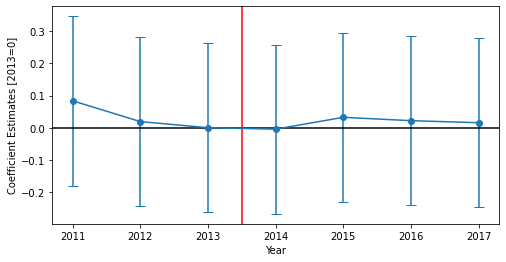

In [ ]:
# Plot coefficient for each year with the confidence interval
plot_graph(year_coef_emp)

In [ ]:
# perform triple difference regression, as illustrated in Equation (2)
reg_emp = smf.ols(formula='log_employment ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_emp).fit()
reg_emp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_employment   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1475.
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.03e-25
Time:                        02:25:39   Log-Likelihood:                 69.161
No. Observations:                  28   AIC:                            -122.3
Df Residuals:                      20   BIC:                            -111.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            12.5773      0.014    899.603      0.000      12.548      12.607
is_after_reform                       0.1067      0.018      5.767      0.000       0.068       0.145
is_manu                               0.8220      0.020     41.575      0.000       0.781       0.863
is_after_reform:is_manu              -0.1022      0.026     -3.906      0.001      -0.157      -0.048
is_quebec                            -0.4543      0.020    -22.977      0.000      -0.496      -0.413
is_after_reform:is_quebec            -0.1101      0.026     -4.210      0.000      -0.165      -0.056
is_manu:is_quebec                    -0.0092      0.028     -0.327      0.747      -0.067       0.049
is_after_reform:is_manu:is_quebec     0.0888      0.037      2.400      0.026       0.012       0.166
==============================================================================
Omnibus:                        2.671   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                1.375
Skew:                          -0.175   Prob(JB):                        0.503
Kurtosis:                       4.028   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Wages Data

### Total employees, all wages

#### Full-time worker, all age groups, all genders

In [ ]:
# get raw data URL from github
all_wages_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/all_wages.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_all_wages = pd.read_csv(all_wages_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_all_wages = df_all_wages.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'all_wages'})

In [ ]:
# clean data using pre-defined clean_data() function
df_all_wages = clean_data(df_all_wages, 'all_wages', 1)

df_all_wages

,province,sector,year,all_wages,theta_year,beta_year,gamma_year,log_all_wages,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,180.399994,2011,2011,2011,5.195177,1,0,0,0
1,Quebec,Construction,2012,184.600006,2012,2012,2012,5.218191,1,0,0,0
2,Quebec,Construction,2013,192.600006,2013,2013,2013,5.260615,1,0,0,0
3,Quebec,Construction,2014,175.199997,2014,2014,2014,5.165928,1,0,1,0
4,Quebec,Construction,2015,162.100006,2015,2015,2015,5.088213,1,0,1,0
5,Quebec,Construction,2016,164.699997,2016,2016,2016,5.104125,1,0,1,0
6,Quebec,Construction,2017,176.000000,2017,2017,2017,5.170484,1,0,1,0
7,Quebec,Manufacturing,2011,456.700012,2011,2011,2011,6.124027,1,1,0,1
8,Quebec,Manufacturing,2012,459.299988,2012,2012,2012,6.129704,1,1,0,1
9,Quebec,Manufacturing,2013,461.100006,2013,2013,2013,6.133615,1,1,0,1


In [ ]:
# perform regression based on Equation (1) in the paper
validation_all_wages = smf.ols(formula='log_all_wages ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_all_wages).fit()
validation_all_wages.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_all_wages   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     77.34
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.22e-05
Time:                        02:25:39   Log-Likelihood:                 57.569
No. Observations:                  28   AIC:                            -71.14
Df Residuals:                       6   BIC:                            -41.83
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 5.7260      0.025    226.496      0.000       5.664       5.788
C(theta_year)[2011]:is_manu:is_quebec    -0.0220      0.107     -0.205      0.844      -0.285       0.241
C(theta_year)[2012]:is_manu:is_quebec    -0.0479      0.107     -0.445      0.672      -0.311       0.215
C(theta_year)[2013]:is_manu:is_quebec    -0.0524      0.107     -0.488      0.643      -0.315       0.210
C(theta_year)[2014]:is_manu:is_quebec     0.0435      0.107      0.405      0.700      -0.219       0.306
C(theta_year)[2015]:is_manu:is_quebec     0.1063      0.107      0.990      0.361      -0.157       0.369
C(theta_year)[2016]:is_manu:is_quebec     0.0872      0.107      0.812      0.448      -0.176       0.350
C(theta_year)[2017]:is_manu:is_quebec    -0.0115      0.107     -0.107      0.918      -0.274       0.251
is_manu                                   0.8477      0.072     11.855      0.000       0.673       1.023
C(beta_year)[T.2012]:is_manu              0.0085      0.095      0.090      0.931      -0.223       0.240
C(beta_year)[T.2013]:is_manu             -0.0255      0.095     -0.269      0.797      -0.257       0.206
C(beta_year)[T.2014]:is_manu             -0.0453      0.095     -0.479      0.649      -0.277       0.186
C(beta_year)[T.2015]:is_manu             -0.0393      0.095     -0.416      0.692      -0.271       0.192
C(beta_year)[T.2016]:is_manu             -0.0316      0.095     -0.334      0.749      -0.263       0.200
C(beta_year)[T.2017]:is_manu             -0.0088      0.095     -0.093      0.929      -0.240       0.223
is_quebec                                -0.5308      0.072     -7.423      0.000      -0.706      -0.356
C(gamma_year)[T.2012]:is_quebec           0.0230      0.095      0.243      0.816      -0.208       0.254
C(gamma_year)[T.2013]:is_quebec           0.0654      0.095      0.692      0.515      -0.166       0.297
C(gamma_year)[T.2014]:is_quebec          -0.0292      0.095     -0.309      0.768      -0.261       0.202
C(gamma_year)[T.2015]:is_quebec          -0.1070      0.095     -1.131      0.301      -0.338       0.124
C(gamma_year)[T.2016]:is_quebec          -0.0911      0.095     -0.963      0.373      -0.323       0.140
C(gamma_year)[T.2017]:is_quebec          -0.0247      0.095     -0.261      0.803      -0.256       0.207
is_manu_quebec                            0.1032      0.044      2.332      0.058      -0.005       0.211
==============================================================================
Omnibus:                       13.156   Durbin-Watson:                   0.798
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.943
Skew:                           0.866   Prob(JB):                     2.83e-05
Kurtosis:  

In [ ]:
year_coef_all_wages = validation_coef(validation_all_wages.summary())
year_coef_all_wages

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,-0.0220,0.107,-0.205,0.844,-0.285,0.241,0.0304,0.2630,0.2630
2,2012,-0.0479,0.107,-0.445,0.672,-0.311,0.215,0.0045,0.2631,0.2629
3,2013,-0.0524,0.107,-0.488,0.643,-0.315,0.210,0.0000,0.2626,0.2624
4,2014,0.0435,0.107,0.405,0.700,-0.219,0.306,0.0959,0.2625,0.2625
5,2015,0.1063,0.107,0.990,0.361,-0.157,0.369,0.1587,0.2633,0.2627
6,2016,0.0872,0.107,0.812,0.448,-0.176,0.350,0.1396,0.2632,0.2628
7,2017,-0.0115,0.107,-0.107,0.918,-0.274,0.251,0.0409,0.2625,0.2625


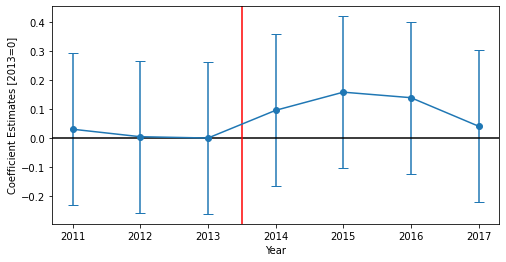

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_all_wages)

In [ ]:
# perform regression based on equation (2) in the paper
reg_all_wages = smf.ols(formula='log_all_wages ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                                       + is_after_reform * is_manu * is_quebec',
                        data=df_all_wages).fit()
reg_all_wages.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_all_wages   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1256.
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           5.11e-25
Time:                        02:25:40   Log-Likelihood:                 64.340
No. Observations:                  28   AIC:                            -112.7
Df Residuals:                      20   BIC:                            -102.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             5.6652      0.017    341.110      0.000       5.631       5.700
is_after_reform                       0.1063      0.022      4.838      0.000       0.060       0.152
is_manu                               0.9028      0.023     38.436      0.000       0.854       0.952
is_after_reform:is_manu              -0.1319      0.031     -4.245      0.000      -0.197      -0.067
is_quebec                            -0.4406      0.023    -18.758      0.000      -0.490      -0.392
is_after_reform:is_quebec            -0.1988      0.031     -6.397      0.000      -0.264      -0.134
is_manu:is_quebec                     0.0017      0.033      0.051      0.960      -0.068       0.071
is_after_reform:is_manu:is_quebec     0.2034      0.044      4.630      0.000       0.112       0.295
==============================================================================
Omnibus:                        0.181   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.105
Skew:                           0.123   Prob(JB):                        0.949
Kurtosis:                       2.829   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Part-time worker, all age groups, all genders

In [ ]:
# get raw data URL from github
all_wages_pt_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/all_wages_parttime.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_all_wages_pt = pd.read_csv(all_wages_pt_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_all_wages_pt = df_all_wages_pt.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'all_wages'})

In [ ]:
# clean data using the pre-defined function
df_all_wages_pt = clean_data(df_all_wages_pt, 'all_wages', 1)

df_all_wages_pt

,province,sector,year,all_wages,theta_year,beta_year,gamma_year,log_all_wages,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,10.700000,2011,2011,2011,2.370244,1,0,0,0
1,Quebec,Construction,2012,9.900000,2012,2012,2012,2.292535,1,0,0,0
2,Quebec,Construction,2013,11.500000,2013,2013,2013,2.442347,1,0,0,0
3,Quebec,Construction,2014,8.800000,2014,2014,2014,2.174752,1,0,1,0
4,Quebec,Construction,2015,10.600000,2015,2015,2015,2.360854,1,0,1,0
5,Quebec,Construction,2016,9.600000,2016,2016,2016,2.261763,1,0,1,0
6,Quebec,Construction,2017,9.600000,2017,2017,2017,2.261763,1,0,1,0
7,Quebec,Manufacturing,2011,20.000000,2011,2011,2011,2.995732,1,1,0,1
8,Quebec,Manufacturing,2012,21.100000,2012,2012,2012,3.049273,1,1,0,1
9,Quebec,Manufacturing,2013,18.299999,2013,2013,2013,2.906901,1,1,0,1


In [ ]:
# perform regression based on Equation (1) in the paper
validation_all_wages_pt = smf.ols(formula='log_all_wages ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_all_wages_pt).fit()
validation_all_wages_pt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_all_wages   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     8.323
Date:                Sat, 17 Dec 2022   Prob (F-statistic):            0.00725
Time:                        02:25:41   Log-Likelihood:                 36.925
No. Observations:                  28   AIC:                            -29.85
Df Residuals:                       6   BIC:                           -0.5422
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 2.8235      0.053     53.432      0.000       2.694       2.953
C(theta_year)[2011]:is_manu:is_quebec     0.1343      0.225      0.598      0.572      -0.415       0.684
C(theta_year)[2012]:is_manu:is_quebec     0.0649      0.225      0.289      0.782      -0.485       0.614
C(theta_year)[2013]:is_manu:is_quebec    -0.2309      0.225     -1.028      0.344      -0.780       0.319
C(theta_year)[2014]:is_manu:is_quebec     0.1599      0.225      0.712      0.503      -0.390       0.709
C(theta_year)[2015]:is_manu:is_quebec    -0.0774      0.225     -0.345      0.742      -0.627       0.472
C(theta_year)[2016]:is_manu:is_quebec    -0.0654      0.225     -0.291      0.781      -0.615       0.484
C(theta_year)[2017]:is_manu:is_quebec     0.2157      0.225      0.961      0.374      -0.334       0.765
is_manu                                   0.2900      0.149      1.941      0.100      -0.076       0.656
C(beta_year)[T.2012]:is_manu              0.2007      0.198      1.015      0.349      -0.283       0.684
C(beta_year)[T.2013]:is_manu              0.2043      0.198      1.033      0.341      -0.280       0.688
C(beta_year)[T.2014]:is_manu              0.1133      0.198      0.573      0.587      -0.370       0.597
C(beta_year)[T.2015]:is_manu              0.0933      0.198      0.472      0.654      -0.391       0.577
C(beta_year)[T.2016]:is_manu              0.1860      0.198      0.941      0.383      -0.298       0.670
C(beta_year)[T.2017]:is_manu              0.1711      0.198      0.866      0.420      -0.313       0.655
is_quebec                                -0.4532      0.149     -3.032      0.023      -0.819      -0.088
C(gamma_year)[T.2012]:is_quebec          -0.0777      0.198     -0.393      0.708      -0.562       0.406
C(gamma_year)[T.2013]:is_quebec           0.0721      0.198      0.365      0.728      -0.412       0.556
C(gamma_year)[T.2014]:is_quebec          -0.1955      0.198     -0.989      0.361      -0.679       0.288
C(gamma_year)[T.2015]:is_quebec          -0.0094      0.198     -0.047      0.964      -0.493       0.474
C(gamma_year)[T.2016]:is_quebec          -0.1085      0.198     -0.549      0.603      -0.592       0.375
C(gamma_year)[T.2017]:is_quebec          -0.1085      0.198     -0.549      0.603      -0.592       0.375
is_manu_quebec                            0.2011      0.092      2.175      0.073      -0.025       0.427
==============================================================================
Omnibus:                       42.789   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.630
Skew:                           2.808   Prob(JB):                     8.20e-46
Kurtosis:  

In [ ]:
year_coef_all_wages_pt = validation_coef(validation_all_wages_pt.summary())
year_coef_all_wages_pt

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,0.1343,0.225,0.598,0.572,-0.415,0.684,0.3652,0.5493,0.5497
2,2012,0.0649,0.225,0.289,0.782,-0.485,0.614,0.2958,0.5499,0.5491
3,2013,-0.2309,0.225,-1.028,0.344,-0.780,0.319,0.0000,0.5491,0.5499
4,2014,0.1599,0.225,0.712,0.503,-0.390,0.709,0.3908,0.5499,0.5491
5,2015,-0.0774,0.225,-0.345,0.742,-0.627,0.472,0.1535,0.5496,0.5494
6,2016,-0.0654,0.225,-0.291,0.781,-0.615,0.484,0.1655,0.5496,0.5494
7,2017,0.2157,0.225,0.961,0.374,-0.334,0.765,0.4466,0.5497,0.5493


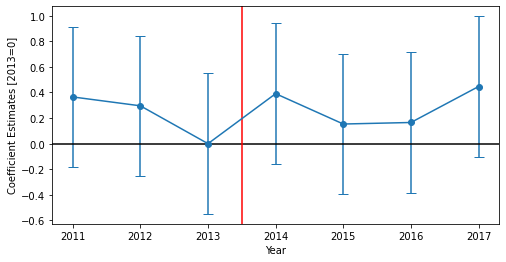

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_all_wages_pt)

In [ ]:
# perform regression based on function (2) in the paper
reg_all_wages_pt = smf.ols(formula='log_all_wages ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                                       + is_after_reform * is_manu * is_quebec',
                        data=df_all_wages_pt).fit()
reg_all_wages_pt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_all_wages   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     39.96
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.12e-10
Time:                        02:25:41   Log-Likelihood:                 27.148
No. Observations:                  28   AIC:                            -38.30
Df Residuals:                      20   BIC:                            -27.64
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.8022      0.063     44.702      0.000       2.671       2.933
is_after_reform                       0.0372      0.083      0.448      0.659      -0.136       0.210
is_manu                               0.4463      0.089      5.034      0.000       0.261       0.631
is_after_reform:is_manu              -0.0312      0.117     -0.266      0.793      -0.276       0.213
is_quebec                            -0.4339      0.089     -4.894      0.000      -0.619      -0.249
is_after_reform:is_quebec            -0.1408      0.117     -1.200      0.244      -0.385       0.104
is_manu:is_quebec                     0.1693      0.125      1.351      0.192      -0.092       0.431
is_after_reform:is_manu:is_quebec     0.1059      0.166      0.639      0.530      -0.240       0.452
==============================================================================
Omnibus:                        7.181   Durbin-Watson:                   2.625
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                5.286
Skew:                           0.913   Prob(JB):                       0.0712
Kurtosis:                       4.092   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Average hourly wage rate

#### Full-time worker, all age groups, all genders

In [ ]:
# get raw data URL from github
hourly_wage_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/hourly_wage.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_hourly_wage = pd.read_csv(hourly_wage_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_hourly_wage = df_hourly_wage.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'hourly_wage'})

In [ ]:
# clean data using pre-defined function
df_hourly_wage = clean_data(df_hourly_wage, 'hourly_wage', 2)

df_hourly_wage

,province,sector,year,hourly_wage,theta_year,beta_year,gamma_year,log_hourly_wage,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,24.790001,2011,2011,2011,3.210440,1,0,0,0
1,Quebec,Construction,2012,25.480000,2012,2012,2012,3.237894,1,0,0,0
2,Quebec,Construction,2013,26.240000,2013,2013,2013,3.267285,1,0,0,0
3,Quebec,Construction,2014,26.680000,2014,2014,2014,3.283914,1,0,1,0
4,Quebec,Construction,2015,27.129999,2015,2015,2015,3.300640,1,0,1,0
5,Quebec,Construction,2016,28.320000,2016,2016,2016,3.343568,1,0,1,0
6,Quebec,Construction,2017,29.299999,2017,2017,2017,3.377588,1,0,1,0
7,Quebec,Manufacturing,2011,21.760000,2011,2011,2011,3.080073,1,1,0,1
8,Quebec,Manufacturing,2012,22.650000,2012,2012,2012,3.120160,1,1,0,1
9,Quebec,Manufacturing,2013,22.790001,2013,2013,2013,3.126322,1,1,0,1


In [ ]:
# perform regression based on Equation (1) in the paper
validation_hourly_wage = smf.ols(formula='log_hourly_wage ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_hourly_wage).fit()
validation_hourly_wage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_hourly_wage   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     1.804
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.239
Time:                        02:25:42   Log-Likelihood:                 63.283
No. Observations:                  28   AIC:                            -82.57
Df Residuals:                       6   BIC:                            -53.26
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 3.2708      0.021    158.671      0.000       3.220       3.321
C(theta_year)[2011]:is_manu:is_quebec     0.0305      0.088      0.348      0.740      -0.184       0.245
C(theta_year)[2012]:is_manu:is_quebec     0.0323      0.088      0.369      0.725      -0.182       0.247
C(theta_year)[2013]:is_manu:is_quebec    -0.0165      0.088     -0.189      0.857      -0.231       0.198
C(theta_year)[2014]:is_manu:is_quebec    -0.0017      0.088     -0.019      0.985      -0.216       0.213
C(theta_year)[2015]:is_manu:is_quebec    -0.0226      0.088     -0.258      0.805      -0.237       0.192
C(theta_year)[2016]:is_manu:is_quebec    -0.0478      0.088     -0.545      0.605      -0.262       0.167
C(theta_year)[2017]:is_manu:is_quebec    -0.0426      0.088     -0.487      0.644      -0.257       0.172
is_manu                                  -0.0924      0.058     -1.584      0.164      -0.235       0.050
C(beta_year)[T.2012]:is_manu              0.0108      0.077      0.140      0.894      -0.178       0.200
C(beta_year)[T.2013]:is_manu              0.0364      0.077      0.472      0.654      -0.152       0.225
C(beta_year)[T.2014]:is_manu              0.0500      0.077      0.648      0.541      -0.139       0.239
C(beta_year)[T.2015]:is_manu              0.0626      0.077      0.811      0.448      -0.126       0.251
C(beta_year)[T.2016]:is_manu              0.0641      0.077      0.831      0.438      -0.125       0.253
C(beta_year)[T.2017]:is_manu              0.0559      0.077      0.725      0.496      -0.133       0.245
is_quebec                                -0.0604      0.058     -1.036      0.340      -0.203       0.082
C(gamma_year)[T.2012]:is_quebec           0.0275      0.077      0.356      0.734      -0.161       0.216
C(gamma_year)[T.2013]:is_quebec           0.0568      0.077      0.737      0.489      -0.132       0.246
C(gamma_year)[T.2014]:is_quebec           0.0735      0.077      0.953      0.378      -0.115       0.262
C(gamma_year)[T.2015]:is_quebec           0.0902      0.077      1.169      0.287      -0.099       0.279
C(gamma_year)[T.2016]:is_quebec           0.1331      0.077      1.726      0.135      -0.056       0.322
C(gamma_year)[T.2017]:is_quebec           0.1671      0.077      2.167      0.073      -0.022       0.356
is_manu_quebec                           -0.0685      0.036     -1.898      0.107      -0.157       0.020
==============================================================================
Omnibus:                        5.378   Durbin-Watson:                   0.702
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.687
Skew:                          -0.021   Prob(JB):                       0.0582
Kurtosis:  

In [ ]:
year_coef_hourly_wage = validation_coef(validation_hourly_wage.summary())
year_coef_hourly_wage

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,0.0305,0.088,0.348,0.740,-0.184,0.245,0.0470,0.2145,0.2145
2,2012,0.0323,0.088,0.369,0.725,-0.182,0.247,0.0488,0.2143,0.2147
3,2013,-0.0165,0.088,-0.189,0.857,-0.231,0.198,0.0000,0.2145,0.2145
4,2014,-0.0017,0.088,-0.019,0.985,-0.216,0.213,0.0148,0.2143,0.2147
5,2015,-0.0226,0.088,-0.258,0.805,-0.237,0.192,-0.0061,0.2144,0.2146
6,2016,-0.0478,0.088,-0.545,0.605,-0.262,0.167,-0.0313,0.2142,0.2148
7,2017,-0.0426,0.088,-0.487,0.644,-0.257,0.172,-0.0261,0.2144,0.2146


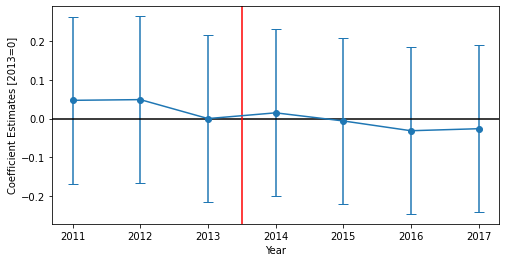

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_hourly_wage)

In [ ]:
# perform triple difference regression, as illustrated in Equation (2)
reg_hourly_wage = smf.ols(formula='log_hourly_wage ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_hourly_wage).fit()
reg_hourly_wage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_hourly_wage   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     21.86
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           4.57e-08
Time:                        02:25:42   Log-Likelihood:                 65.635
No. Observations:                  28   AIC:                            -115.3
Df Residuals:                      20   BIC:                            -104.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             3.2194      0.016    203.024      0.000       3.186       3.252
is_after_reform                       0.0900      0.021      4.290      0.000       0.046       0.134
is_manu                              -0.0252      0.022     -1.125      0.274      -0.072       0.022
is_after_reform:is_manu              -0.0476      0.030     -1.604      0.124      -0.109       0.014
is_quebec                             0.0191      0.022      0.852      0.404      -0.028       0.066
is_after_reform:is_quebec            -0.0021      0.030     -0.071      0.944      -0.064       0.060
is_manu:is_quebec                    -0.1045      0.032     -3.294      0.004      -0.171      -0.038
is_after_reform:is_manu:is_quebec     0.0459      0.042      1.094      0.287      -0.042       0.133
==============================================================================
Omnibus:                        0.073   Durbin-Watson:                   2.392
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.232
Skew:                          -0.102   Prob(JB):                        0.891
Kurtosis:                       2.604   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Part-time worker, all age groups, all genders

In [ ]:
# get raw data URL from github
hourly_wage_pt_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/hourly_wage_parttime.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_hourly_wage_pt = pd.read_csv(hourly_wage_pt_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_hourly_wage_pt = df_hourly_wage_pt.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'hourly_wage'})

In [ ]:
# clean data using pre-defined function
df_hourly_wage_pt = clean_data(df_hourly_wage_pt, 'hourly_wage', 2)

df_hourly_wage_pt

,province,sector,year,hourly_wage,theta_year,beta_year,gamma_year,log_hourly_wage,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,18.740000,2011,2011,2011,2.930660,1,0,0,0
1,Quebec,Construction,2012,18.980000,2012,2012,2012,2.943386,1,0,0,0
2,Quebec,Construction,2013,19.010000,2013,2013,2013,2.944965,1,0,0,0
3,Quebec,Construction,2014,20.730000,2014,2014,2014,3.031582,1,0,1,0
4,Quebec,Construction,2015,20.219999,2015,2015,2015,3.006672,1,0,1,0
5,Quebec,Construction,2016,21.180000,2016,2016,2016,3.053057,1,0,1,0
6,Quebec,Construction,2017,22.360001,2017,2017,2017,3.107274,1,0,1,0
7,Quebec,Manufacturing,2011,15.060000,2011,2011,2011,2.712042,1,1,0,1
8,Quebec,Manufacturing,2012,15.750000,2012,2012,2012,2.756840,1,1,0,1
9,Quebec,Manufacturing,2013,17.330000,2013,2013,2013,2.852439,1,1,0,1


In [ ]:
# perform regression based on Equation (1) in the paper
validation_hourly_wage_pt = smf.ols(formula='log_hourly_wage ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_hourly_wage_pt).fit()
validation_hourly_wage_pt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_hourly_wage   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     1.847
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.229
Time:                        02:25:43   Log-Likelihood:                 52.622
No. Observations:                  28   AIC:                            -61.24
Df Residuals:                       6   BIC:                            -31.94
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 2.9702      0.030     98.462      0.000       2.896       3.044
C(theta_year)[2011]:is_manu:is_quebec    -0.0156      0.128     -0.121      0.907      -0.329       0.298
C(theta_year)[2012]:is_manu:is_quebec    -0.0079      0.128     -0.062      0.953      -0.322       0.306
C(theta_year)[2013]:is_manu:is_quebec     0.1188      0.128      0.927      0.390      -0.195       0.433
C(theta_year)[2014]:is_manu:is_quebec     0.0207      0.128      0.162      0.877      -0.293       0.334
C(theta_year)[2015]:is_manu:is_quebec    -0.0477      0.128     -0.372      0.722      -0.361       0.266
C(theta_year)[2016]:is_manu:is_quebec    -0.0451      0.128     -0.352      0.737      -0.359       0.269
C(theta_year)[2017]:is_manu:is_quebec    -0.0880      0.128     -0.687      0.518      -0.402       0.226
is_manu                                  -0.1382      0.085     -1.620      0.156      -0.347       0.071
C(beta_year)[T.2012]:is_manu              0.0244      0.113      0.216      0.836      -0.252       0.301
C(beta_year)[T.2013]:is_manu             -0.0083      0.113     -0.073      0.944      -0.284       0.268
C(beta_year)[T.2014]:is_manu             -0.0532      0.113     -0.471      0.654      -0.329       0.223
C(beta_year)[T.2015]:is_manu              0.0279      0.113      0.247      0.813      -0.248       0.304
C(beta_year)[T.2016]:is_manu              0.1156      0.113      1.024      0.345      -0.161       0.392
C(beta_year)[T.2017]:is_manu              0.0483      0.113      0.428      0.684      -0.228       0.324
is_quebec                                -0.0396      0.085     -0.464      0.659      -0.248       0.169
C(gamma_year)[T.2012]:is_quebec           0.0127      0.113      0.113      0.914      -0.263       0.289
C(gamma_year)[T.2013]:is_quebec           0.0143      0.113      0.127      0.903      -0.262       0.290
C(gamma_year)[T.2014]:is_quebec           0.1009      0.113      0.894      0.406      -0.175       0.377
C(gamma_year)[T.2015]:is_quebec           0.0760      0.113      0.673      0.526      -0.200       0.352
C(gamma_year)[T.2016]:is_quebec           0.1224      0.113      1.084      0.320      -0.154       0.399
C(gamma_year)[T.2017]:is_quebec           0.1766      0.113      1.565      0.169      -0.100       0.453
is_manu_quebec                           -0.0648      0.053     -1.228      0.265      -0.194       0.064
==============================================================================
Omnibus:                       25.691   Durbin-Watson:                   0.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.160
Skew:                          -1.678   Prob(JB):                     4.30e-15
Kurtosis:  

In [ ]:
year_coef_hourly_wage_pt = validation_coef(validation_hourly_wage_pt.summary())
year_coef_hourly_wage_pt

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,-0.0156,0.128,-0.121,0.907,-0.329,0.298,-0.1344,0.3134,0.3136
2,2012,-0.0079,0.128,-0.062,0.953,-0.322,0.306,-0.1267,0.3141,0.3139
3,2013,0.1188,0.128,0.927,0.390,-0.195,0.433,0.0000,0.3138,0.3142
4,2014,0.0207,0.128,0.162,0.877,-0.293,0.334,-0.0981,0.3137,0.3133
5,2015,-0.0477,0.128,-0.372,0.722,-0.361,0.266,-0.1665,0.3133,0.3137
6,2016,-0.0451,0.128,-0.352,0.737,-0.359,0.269,-0.1639,0.3139,0.3141
7,2017,-0.0880,0.128,-0.687,0.518,-0.402,0.226,-0.2068,0.3140,0.3140


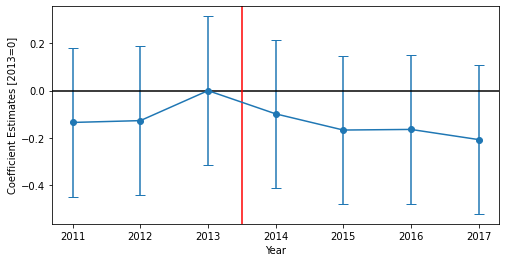

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_hourly_wage_pt)

In [ ]:
# perform triple difference regression, as illustrated in Equation (2)
reg_hourly_wage_pt = smf.ols(formula='log_hourly_wage ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_hourly_wage_pt).fit()
reg_hourly_wage_pt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_hourly_wage   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     12.80
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           3.69e-06
Time:                        02:25:43   Log-Likelihood:                 48.295
No. Observations:                  28   AIC:                            -80.59
Df Residuals:                      20   BIC:                            -69.93
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.8955      0.029     98.298      0.000       2.834       2.957
is_after_reform                       0.1308      0.039      3.356      0.003       0.049       0.212
is_manu                              -0.0581      0.042     -1.394      0.178      -0.145       0.029
is_after_reform:is_manu              -0.1015      0.055     -1.842      0.080      -0.216       0.013
is_quebec                             0.0442      0.042      1.060      0.302      -0.043       0.131
is_after_reform:is_quebec            -0.0208      0.055     -0.377      0.710      -0.136       0.094
is_manu:is_quebec                    -0.1078      0.059     -1.830      0.082      -0.231       0.015
is_after_reform:is_manu:is_quebec     0.0590      0.078      0.757      0.458      -0.104       0.222
==============================================================================
Omnibus:                        0.087   Durbin-Watson:                   2.386
Prob(Omnibus):                  0.957   Jarque-Bera (JB):                0.199
Skew:                           0.116   Prob(JB):                        0.905
Kurtosis:                       2.658   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Investment Data

### Total non-residential capital

In [ ]:
# get raw data URL from github
inv_non_res_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_non_res.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_non_res = pd.read_csv(inv_non_res_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_non_res = df_inv_non_res.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [ ]:
# clean data with pre-defined function
df_inv_non_res = clean_data(df_inv_non_res, 'investment', 0)

df_inv_non_res

,province,sector,year,investment,theta_year,beta_year,gamma_year,log_investment,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,1257,2011,2011,2011,7.136483,1,0,0,0
1,Quebec,Construction,2012,1177,2012,2012,2012,7.070724,1,0,0,0
2,Quebec,Construction,2013,1200,2013,2013,2013,7.090077,1,0,0,0
3,Quebec,Construction,2014,861,2014,2014,2014,6.758095,1,0,1,0
4,Quebec,Construction,2015,878,2015,2015,2015,6.777647,1,0,1,0
5,Quebec,Construction,2016,828,2016,2016,2016,6.719013,1,0,1,0
6,Quebec,Construction,2017,1154,2017,2017,2017,7.050989,1,0,1,0
7,Quebec,Manufacturing,2011,6727,2011,2011,2011,8.813885,1,1,0,1
8,Quebec,Manufacturing,2012,6717,2012,2012,2012,8.812397,1,1,0,1
9,Quebec,Manufacturing,2013,6434,2013,2013,2013,8.769352,1,1,0,1


In [ ]:
# perform regression based on Equation (1) in the paper
validation_inv_non_res = smf.ols(formula='log_investment ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_inv_non_res).fit()
validation_inv_non_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_investment   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     320.0
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.77e-07
Time:                        02:25:44   Log-Likelihood:                 62.185
No. Observations:                  28   AIC:                            -80.37
Df Residuals:                       6   BIC:                            -51.06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 7.4046      0.021    345.393      0.000       7.352       7.457
C(theta_year)[2011]:is_manu:is_quebec    -0.1045      0.091     -1.147      0.295      -0.327       0.118
C(theta_year)[2012]:is_manu:is_quebec    -0.0671      0.091     -0.737      0.489      -0.290       0.156
C(theta_year)[2013]:is_manu:is_quebec    -0.0250      0.091     -0.274      0.793      -0.248       0.198
C(theta_year)[2014]:is_manu:is_quebec     0.2317      0.091      2.543      0.044       0.009       0.455
C(theta_year)[2015]:is_manu:is_quebec     0.0087      0.091      0.096      0.927      -0.214       0.232
C(theta_year)[2016]:is_manu:is_quebec     0.2491      0.091      2.734      0.034       0.026       0.472
C(theta_year)[2017]:is_manu:is_quebec    -0.1072      0.091     -1.176      0.284      -0.330       0.116
is_manu                                   1.5962      0.061     26.324      0.000       1.448       1.745
C(beta_year)[T.2012]:is_manu              0.0269      0.080      0.335      0.749      -0.169       0.223
C(beta_year)[T.2013]:is_manu             -0.0777      0.080     -0.968      0.370      -0.274       0.119
C(beta_year)[T.2014]:is_manu              0.0497      0.080      0.619      0.559      -0.147       0.246
C(beta_year)[T.2015]:is_manu              0.0939      0.080      1.170      0.286      -0.102       0.290
C(beta_year)[T.2016]:is_manu             -0.0810      0.080     -1.010      0.352      -0.277       0.115
C(beta_year)[T.2017]:is_manu              0.0236      0.080      0.295      0.778      -0.173       0.220
is_quebec                                -0.2682      0.061     -4.422      0.004      -0.417      -0.120
C(gamma_year)[T.2012]:is_quebec          -0.0658      0.080     -0.820      0.444      -0.262       0.131
C(gamma_year)[T.2013]:is_quebec          -0.0464      0.080     -0.579      0.584      -0.243       0.150
C(gamma_year)[T.2014]:is_quebec          -0.3784      0.080     -4.717      0.003      -0.575      -0.182
C(gamma_year)[T.2015]:is_quebec          -0.3588      0.080     -4.473      0.004      -0.555      -0.163
C(gamma_year)[T.2016]:is_quebec          -0.4175      0.080     -5.204      0.002      -0.614      -0.221
C(gamma_year)[T.2017]:is_quebec          -0.0855      0.080     -1.066      0.328      -0.282       0.111
is_manu_quebec                            0.1857      0.038      4.951      0.003       0.094       0.278
==============================================================================
Omnibus:                        9.779   Durbin-Watson:                   2.711
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               14.690
Skew:                          -0.540   Prob(JB):                     0.000646
Kurtosis:  

In [ ]:
year_coef_inv_non_res = validation_coef(validation_inv_non_res.summary())
year_coef_inv_non_res

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,-0.1045,0.091,-1.147,0.295,-0.327,0.118,-0.0795,0.2225,0.2225
2,2012,-0.0671,0.091,-0.737,0.489,-0.290,0.156,-0.0421,0.2229,0.2231
3,2013,-0.0250,0.091,-0.274,0.793,-0.248,0.198,0.0000,0.2230,0.2230
4,2014,0.2317,0.091,2.543,0.044,0.009,0.455,0.2567,0.2227,0.2233
5,2015,0.0087,0.091,0.096,0.927,-0.214,0.232,0.0337,0.2227,0.2233
6,2016,0.2491,0.091,2.734,0.034,0.026,0.472,0.2741,0.2231,0.2229
7,2017,-0.1072,0.091,-1.176,0.284,-0.330,0.116,-0.0822,0.2228,0.2232


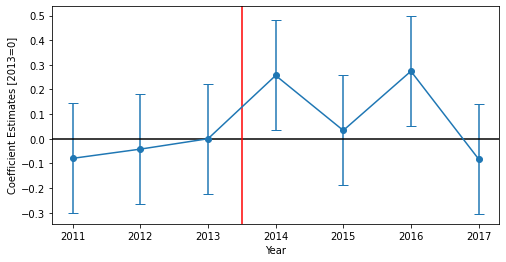

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_inv_non_res)

In [ ]:
# perform triple difference regression, as illustrated in Equation (2)
reg_inv_non_res = smf.ols(formula='log_investment ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_inv_non_res).fit()
reg_inv_non_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_investment   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     468.3
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           9.42e-21
Time:                        02:25:45   Log-Likelihood:                 35.352
No. Observations:                  28   AIC:                            -54.70
Df Residuals:                      20   BIC:                            -44.05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.4079      0.047    158.399      0.000       7.310       7.505
is_after_reform                      -0.0058      0.062     -0.093      0.927      -0.135       0.123
is_manu                               1.5760      0.066     23.828      0.000       1.438       1.714
is_after_reform:is_manu               0.0442      0.087      0.505      0.619      -0.138       0.227
is_quebec                            -0.3088      0.066     -4.670      0.000      -0.447      -0.171
is_after_reform:is_quebec            -0.2669      0.087     -3.051      0.006      -0.449      -0.084
is_manu:is_quebec                     0.1235      0.094      1.320      0.202      -0.072       0.319
is_after_reform:is_manu:is_quebec     0.1554      0.124      1.256      0.224      -0.103       0.414
==============================================================================
Omnibus:                       10.144   Durbin-Watson:                   2.496
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.234
Skew:                           1.005   Prob(JB):                      0.00988
Kurtosis:                       4.968   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Machinery and equipment

In [ ]:
# get raw data URL from github
inv_me_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_machinery_equipment.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_me = pd.read_csv(inv_me_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_me = df_inv_me.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [ ]:
# clean data using pre-defined function
df_inv_me = clean_data(df_inv_me, 'investment', 0)

df_inv_me

,province,sector,year,investment,theta_year,beta_year,gamma_year,log_investment,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,1028,2011,2011,2011,6.935370,1,0,0,0
1,Quebec,Construction,2012,967,2012,2012,2012,6.874198,1,0,0,0
2,Quebec,Construction,2013,962,2013,2013,2013,6.869014,1,0,0,0
3,Quebec,Construction,2014,648,2014,2014,2014,6.473891,1,0,1,0
4,Quebec,Construction,2015,670,2015,2015,2015,6.507278,1,0,1,0
5,Quebec,Construction,2016,634,2016,2016,2016,6.452049,1,0,1,0
6,Quebec,Construction,2017,909,2017,2017,2017,6.812345,1,0,1,0
7,Quebec,Manufacturing,2011,2598,2011,2011,2011,7.862497,1,1,0,1
8,Quebec,Manufacturing,2012,2563,2012,2012,2012,7.848934,1,1,0,1
9,Quebec,Manufacturing,2013,2442,2013,2013,2013,7.800573,1,1,0,1


In [ ]:
# perform regression based on Equation (1) in the paper
validation_inv_me = smf.ols(formula='log_investment ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_inv_me).fit()
validation_inv_me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_investment   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     129.1
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.66e-06
Time:                        02:25:45   Log-Likelihood:                 59.144
No. Observations:                  28   AIC:                            -74.29
Df Residuals:                       6   BIC:                            -44.98
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 7.1484      0.024    299.127      0.000       7.090       7.207
C(theta_year)[2011]:is_manu:is_quebec    -0.2005      0.102     -1.974      0.096      -0.449       0.048
C(theta_year)[2012]:is_manu:is_quebec    -0.1359      0.102     -1.338      0.229      -0.384       0.113
C(theta_year)[2013]:is_manu:is_quebec    -0.0029      0.102     -0.029      0.978      -0.251       0.246
C(theta_year)[2014]:is_manu:is_quebec     0.1338      0.102      1.317      0.236      -0.115       0.382
C(theta_year)[2015]:is_manu:is_quebec     0.0144      0.102      0.141      0.892      -0.234       0.263
C(theta_year)[2016]:is_manu:is_quebec     0.1754      0.102      1.727      0.135      -0.073       0.424
C(theta_year)[2017]:is_manu:is_quebec    -0.1093      0.102     -1.076      0.323      -0.358       0.139
is_manu                                   1.2527      0.068     18.533      0.000       1.087       1.418
C(beta_year)[T.2012]:is_manu             -0.0170      0.089     -0.190      0.856      -0.236       0.202
C(beta_year)[T.2013]:is_manu             -0.1932      0.089     -2.160      0.074      -0.412       0.026
C(beta_year)[T.2014]:is_manu             -0.0287      0.089     -0.321      0.759      -0.248       0.190
C(beta_year)[T.2015]:is_manu             -0.0072      0.089     -0.081      0.938      -0.226       0.212
C(beta_year)[T.2016]:is_manu             -0.1652      0.089     -1.848      0.114      -0.384       0.054
C(beta_year)[T.2017]:is_manu             -0.1174      0.089     -1.313      0.237      -0.336       0.101
is_quebec                                -0.2131      0.068     -3.152      0.020      -0.378      -0.048
C(gamma_year)[T.2012]:is_quebec          -0.0612      0.089     -0.684      0.519      -0.280       0.158
C(gamma_year)[T.2013]:is_quebec          -0.0664      0.089     -0.742      0.486      -0.285       0.152
C(gamma_year)[T.2014]:is_quebec          -0.4615      0.089     -5.161      0.002      -0.680      -0.243
C(gamma_year)[T.2015]:is_quebec          -0.4281      0.089     -4.788      0.003      -0.647      -0.209
C(gamma_year)[T.2016]:is_quebec          -0.4833      0.089     -5.405      0.002      -0.702      -0.265
C(gamma_year)[T.2017]:is_quebec          -0.1230      0.089     -1.376      0.218      -0.342       0.096
is_manu_quebec                           -0.1250      0.042     -2.990      0.024      -0.227      -0.023
==============================================================================
Omnibus:                       11.217   Durbin-Watson:                   2.526
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               18.565
Skew:                          -0.634   Prob(JB):                     9.30e-05
Kurtosis:  

In [ ]:
year_coef_inv_me = validation_coef(validation_inv_me.summary())
year_coef_inv_me

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,-0.2005,0.102,-1.974,0.096,-0.449,0.048,-0.1976,0.2485,0.2485
2,2012,-0.1359,0.102,-1.338,0.229,-0.384,0.113,-0.1330,0.2481,0.2489
3,2013,-0.0029,0.102,-0.029,0.978,-0.251,0.246,0.0000,0.2481,0.2489
4,2014,0.1338,0.102,1.317,0.236,-0.115,0.382,0.1367,0.2488,0.2482
5,2015,0.0144,0.102,0.141,0.892,-0.234,0.263,0.0173,0.2484,0.2486
6,2016,0.1754,0.102,1.727,0.135,-0.073,0.424,0.1783,0.2484,0.2486
7,2017,-0.1093,0.102,-1.076,0.323,-0.358,0.139,-0.1064,0.2487,0.2483


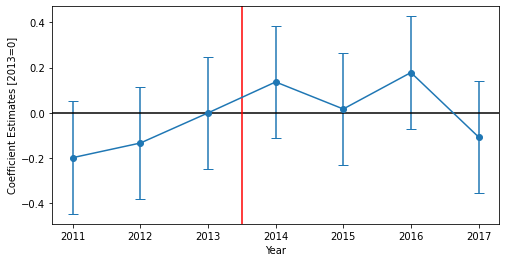

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_inv_me)

In [ ]:
# perform triple difference regression, as illustrated in Equation (2)
reg_inv_me = smf.ols(formula='log_investment ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_inv_me).fit()
reg_inv_me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_investment   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     187.5
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           7.96e-17
Time:                        02:25:46   Log-Likelihood:                 32.309
No. Observations:                  28   AIC:                            -48.62
Df Residuals:                      20   BIC:                            -37.96
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.1619      0.052    137.367      0.000       7.053       7.271
is_after_reform                      -0.0235      0.069     -0.341      0.737      -0.167       0.120
is_manu                               1.1692      0.074     15.857      0.000       1.015       1.323
is_after_reform:is_manu               0.0139      0.098      0.143      0.888      -0.190       0.217
is_quebec                            -0.2690      0.074     -3.648      0.002      -0.423      -0.115
is_after_reform:is_quebec            -0.3080      0.098     -3.158      0.005      -0.511      -0.105
is_manu:is_quebec                    -0.2247      0.104     -2.155      0.044      -0.442      -0.007
is_after_reform:is_manu:is_quebec     0.1432      0.138      1.038      0.312      -0.145       0.431
==============================================================================
Omnibus:                        9.320   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.323
Skew:                           0.918   Prob(JB):                       0.0156
Kurtosis:                       4.939   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Intellectual property products

In [ ]:
# get raw data URL from github
inv_ip_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_ip.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_ip = pd.read_csv(inv_ip_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_ip = df_inv_ip.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [ ]:
# clean data using pre-defined function
df_inv_ip = clean_data(df_inv_ip, 'investment', 0)

df_inv_ip

,province,sector,year,investment,theta_year,beta_year,gamma_year,log_investment,is_quebec,is_manu,is_after_reform,is_manu_quebec
0,Quebec,Construction,2011,52,2011,2011,2011,3.951244,1,0,0,0
1,Quebec,Construction,2012,56,2012,2012,2012,4.025352,1,0,0,0
2,Quebec,Construction,2013,69,2013,2013,2013,4.234107,1,0,0,0
3,Quebec,Construction,2014,66,2014,2014,2014,4.189655,1,0,1,0
4,Quebec,Construction,2015,62,2015,2015,2015,4.127134,1,0,1,0
5,Quebec,Construction,2016,47,2016,2016,2016,3.850148,1,0,1,0
6,Quebec,Construction,2017,56,2017,2017,2017,4.025352,1,0,1,0
7,Quebec,Manufacturing,2011,2650,2011,2011,2011,7.882315,1,1,0,1
8,Quebec,Manufacturing,2012,2643,2012,2012,2012,7.879670,1,1,0,1
9,Quebec,Manufacturing,2013,3010,2013,2013,2013,8.009695,1,1,0,1


In [ ]:
# perform regression based on Equation (1) in the paper
validation_inv_ip = smf.ols(formula='log_investment ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_inv_ip).fit()
validation_inv_ip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_investment   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     276.2
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.76e-07
Time:                        02:25:46   Log-Likelihood:                 40.156
No. Observations:                  28   AIC:                            -36.31
Df Residuals:                       6   BIC:                            -7.004
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 4.8162      0.047    102.290      0.000       4.701       4.931
C(theta_year)[2011]:is_manu:is_quebec     0.1079      0.200      0.539      0.609      -0.382       0.598
C(theta_year)[2012]:is_manu:is_quebec     0.0757      0.200      0.379      0.718      -0.414       0.565
C(theta_year)[2013]:is_manu:is_quebec     0.0025      0.200      0.012      0.991      -0.487       0.492
C(theta_year)[2014]:is_manu:is_quebec     0.1161      0.200      0.580      0.583      -0.374       0.606
C(theta_year)[2015]:is_manu:is_quebec    -0.1136      0.200     -0.568      0.591      -0.603       0.376
C(theta_year)[2016]:is_manu:is_quebec     0.3013      0.200      1.506      0.183      -0.188       0.791
C(theta_year)[2017]:is_manu:is_quebec     0.1194      0.200      0.597      0.573      -0.370       0.609
is_manu                                   3.2139      0.133     24.133      0.000       2.888       3.540
C(beta_year)[T.2012]:is_manu             -0.0446      0.176     -0.253      0.809      -0.476       0.386
C(beta_year)[T.2013]:is_manu             -0.0501      0.176     -0.284      0.786      -0.481       0.381
C(beta_year)[T.2014]:is_manu             -0.0161      0.176     -0.091      0.930      -0.447       0.415
C(beta_year)[T.2015]:is_manu              0.0483      0.176      0.274      0.793      -0.383       0.479
C(beta_year)[T.2016]:is_manu             -0.1199      0.176     -0.680      0.522      -0.551       0.311
C(beta_year)[T.2017]:is_manu              0.0364      0.176      0.207      0.843      -0.395       0.468
is_quebec                                -0.8649      0.133     -6.495      0.001      -1.191      -0.539
C(gamma_year)[T.2012]:is_quebec           0.0741      0.176      0.421      0.689      -0.357       0.505
C(gamma_year)[T.2013]:is_quebec           0.2829      0.176      1.606      0.159      -0.148       0.714
C(gamma_year)[T.2014]:is_quebec           0.2384      0.176      1.353      0.225      -0.193       0.669
C(gamma_year)[T.2015]:is_quebec           0.1759      0.176      0.998      0.357      -0.255       0.607
C(gamma_year)[T.2016]:is_quebec          -0.1011      0.176     -0.574      0.587      -0.532       0.330
C(gamma_year)[T.2017]:is_quebec           0.0741      0.176      0.421      0.689      -0.357       0.505
is_manu_quebec                            0.6093      0.082      7.394      0.000       0.408       0.811
==============================================================================
Omnibus:                       25.392   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.762
Skew:                          -1.853   Prob(JB):                     9.49e-12
Kurtosis:  

In [ ]:
year_coef_inv_ip = validation_coef(validation_inv_ip.summary())
year_coef_inv_ip

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,0.1079,0.2,0.539,0.609,-0.382,0.598,0.1054,0.4899,0.4901
2,2012,0.0757,0.2,0.379,0.718,-0.414,0.565,0.0732,0.4897,0.4893
3,2013,0.0025,0.2,0.012,0.991,-0.487,0.492,0.0000,0.4895,0.4895
4,2014,0.1161,0.2,0.580,0.583,-0.374,0.606,0.1136,0.4901,0.4899
5,2015,-0.1136,0.2,-0.568,0.591,-0.603,0.376,-0.1161,0.4894,0.4896
6,2016,0.3013,0.2,1.506,0.183,-0.188,0.791,0.2988,0.4893,0.4897
7,2017,0.1194,0.2,0.597,0.573,-0.370,0.609,0.1169,0.4894,0.4896


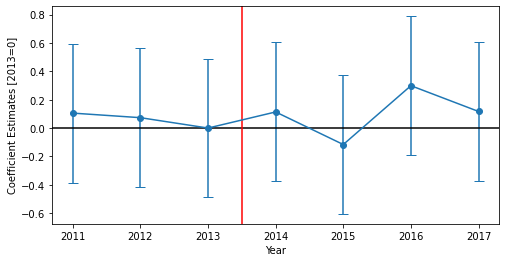

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_inv_ip)

In [ ]:
# perform triple difference regression, as illustrated in Equation (2)
reg_inv_ip = smf.ols(formula='log_investment ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_inv_ip).fit()
reg_inv_ip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_investment   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     996.2
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           5.16e-24
Time:                        02:25:47   Log-Likelihood:                 25.908
No. Observations:                  28   AIC:                            -35.82
Df Residuals:                      20   BIC:                            -25.16
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.8725      0.066     74.358      0.000       4.736       5.009
is_after_reform                      -0.0985      0.087     -1.136      0.269      -0.279       0.082
is_manu                               3.1261      0.093     33.733      0.000       2.933       3.319
is_after_reform:is_manu               0.1173      0.123      0.957      0.350      -0.138       0.373
is_quebec                            -0.8022      0.093     -8.657      0.000      -0.996      -0.609
is_after_reform:is_quebec             0.0764      0.123      0.623      0.540      -0.179       0.332
is_manu:is_quebec                     0.7276      0.131      5.552      0.000       0.454       1.001
is_after_reform:is_manu:is_quebec    -0.0548      0.173     -0.316      0.755      -0.416       0.307
==============================================================================
Omnibus:                        0.569   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.752   Jarque-Bera (JB):                0.628
Skew:                          -0.060   Prob(JB):                        0.730
Kurtosis:                       2.276   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Output Data

In [ ]:
# get raw data URL from github
output_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/output1.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_output_subsec = pd.read_csv(output_url, skiprows=11, skipfooter=12, header=None, engine='python', on_bad_lines='skip')

# name the headers
df_output_subsec = df_output_subsec.rename(columns={0: 'sector', 1: 'year', 2: 'Ontario', 3: 'Quebec'})

df_output_subsec

,sector,year,Ontario,Quebec
0,Residential building construction [BS23A],2011,"19,852.8","32,882.1"
1,NaN,2012,"20,366.7","36,513.1"
2,NaN,2013,"19,239.8","35,983.9"
3,NaN,2014,"19,338.9","36,936.5"
4,NaN,2015,"19,292.3","40,613.0"
5,NaN,2016,"19,986.3","45,169.2"
6,NaN,2017,"22,004.3","48,967.9"
7,Non-residential building construction [BS23B],2011,"8,439.8","17,728.2"
8,NaN,2012,"9,882.7","16,510.1"
9,NaN,2013,"9,130.2","15,126.2"


In [ ]:
# fill all missing values based on the most previously available value of the column
df_output_subsec = df_output_subsec.fillna(method='ffill')

# unpivot the table to match the format of other tables
df_output_subsec = df_output_subsec.melt(id_vars=['sector', 'year'], var_name='province', value_name='output')

# combine all construction subsectors into an overall construction sector
df_output_subsec['sector'].loc[df_output_subsec['sector'].str.contains('construction')] = 'Construction'
df_output_subsec['sector'].loc[df_output_subsec['sector'].str.contains('Manufacturing')] = 'Manufacturing'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# clean data using pre-defined function
df_output_subsec = clean_data(df_output_subsec, 'output', 1)

In [ ]:
df_output = df_output_subsec.groupby(['year', 'theta_year', 'beta_year', 'gamma_year', 
                                 'province', 'sector', 'is_quebec', 'is_manu', 
                                 'is_manu_quebec', 'is_after_reform']).sum('output').reset_index()
df_output['output'] = df_output['output'].round(1)

df_output

,year,theta_year,beta_year,gamma_year,province,sector,is_quebec,is_manu,is_manu_quebec,is_after_reform,output,log_output
0,2011,2011,2011,2011,Ontario,Construction,0,0,0,0,50888.898438,43.576843
1,2011,2011,2011,2011,Ontario,Manufacturing,0,1,0,0,145645.093750,11.888928
2,2011,2011,2011,2011,Quebec,Construction,1,0,0,0,81076.898438,46.371914
3,2011,2011,2011,2011,Quebec,Manufacturing,1,1,1,0,289492.406250,12.575885
4,2012,2012,2012,2012,Ontario,Construction,0,0,0,0,55139.199219,44.003044
5,2012,2012,2012,2012,Ontario,Manufacturing,0,1,0,0,148294.406250,11.906955
6,2012,2012,2012,2012,Quebec,Construction,1,0,0,0,85202.703125,46.515392
7,2012,2012,2012,2012,Quebec,Manufacturing,1,1,1,0,301628.500000,12.616951
8,2013,2013,2013,2013,Ontario,Construction,0,0,0,0,52597.101562,43.848713
9,2013,2013,2013,2013,Ontario,Manufacturing,0,1,0,0,146463.500000,11.894531


In [ ]:
# perform regression based on Equation (1) in the paper
validation_output = smf.ols(formula='log_output ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_output).fit()
validation_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_output   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     8751.
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           8.75e-12
Time:                        02:25:48   Log-Likelihood:                 26.229
No. Observations:                  28   AIC:                            -8.458
Df Residuals:                       6   BIC:                             20.85
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                43.9450      0.077    567.568      0.000      43.756      44.134
C(theta_year)[2011]:is_manu:is_quebec     0.2181      0.329      0.663      0.532      -0.587       1.023
C(theta_year)[2012]:is_manu:is_quebec     0.0976      0.329      0.297      0.777      -0.708       0.903
C(theta_year)[2013]:is_manu:is_quebec     0.0499      0.329      0.152      0.884      -0.755       0.855
C(theta_year)[2014]:is_manu:is_quebec    -0.2402      0.329     -0.730      0.493      -1.045       0.565
C(theta_year)[2015]:is_manu:is_quebec    -0.6767      0.329     -2.056      0.085      -1.482       0.129
C(theta_year)[2016]:is_manu:is_quebec    -0.5388      0.329     -1.637      0.153      -1.344       0.266
C(theta_year)[2017]:is_manu:is_quebec    -0.8679      0.329     -2.638      0.039      -1.673      -0.063
is_manu                                 -32.0561      0.219   -146.377      0.000     -32.592     -31.520
C(beta_year)[T.2012]:is_manu              0.0180      0.290      0.062      0.952      -0.691       0.727
C(beta_year)[T.2013]:is_manu              0.0056      0.290      0.019      0.985      -0.703       0.714
C(beta_year)[T.2014]:is_manu              0.0543      0.290      0.187      0.858      -0.655       0.763
C(beta_year)[T.2015]:is_manu              0.0699      0.290      0.241      0.817      -0.639       0.779
C(beta_year)[T.2016]:is_manu              0.0838      0.290      0.289      0.782      -0.625       0.793
C(beta_year)[T.2017]:is_manu              0.1565      0.290      0.540      0.609      -0.552       0.865
is_quebec                                 2.4269      0.219     11.082      0.000       1.891       2.963
C(gamma_year)[T.2012]:is_quebec           0.1435      0.290      0.495      0.638      -0.565       0.852
C(gamma_year)[T.2013]:is_quebec           0.2024      0.290      0.699      0.511      -0.506       0.911
C(gamma_year)[T.2014]:is_quebec           0.4878      0.290      1.684      0.143      -0.221       1.197
C(gamma_year)[T.2015]:is_quebec           0.9530      0.290      3.289      0.017       0.244       1.662
C(gamma_year)[T.2016]:is_quebec           0.8198      0.290      2.830      0.030       0.111       1.529
C(gamma_year)[T.2017]:is_quebec           1.0902      0.290      3.763      0.009       0.381       1.799
is_manu_quebec                           -1.9580      0.135    -14.451      0.000      -2.290      -1.626
==============================================================================
Omnibus:                       21.346   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.514
Skew:                          -0.932   Prob(JB):                     4.94e-21
Kurtosis:  

In [ ]:
year_coef_output = validation_coef(validation_output.summary())
year_coef_output

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,0.2181,0.329,0.663,0.532,-0.587,1.023,0.1682,0.8051,0.8049
2,2012,0.0976,0.329,0.297,0.777,-0.708,0.903,0.0477,0.8056,0.8054
3,2013,0.0499,0.329,0.152,0.884,-0.755,0.855,0.0000,0.8049,0.8051
4,2014,-0.2402,0.329,-0.730,0.493,-1.045,0.565,-0.2901,0.8048,0.8052
5,2015,-0.6767,0.329,-2.056,0.085,-1.482,0.129,-0.7266,0.8053,0.8057
6,2016,-0.5388,0.329,-1.637,0.153,-1.344,0.266,-0.5887,0.8052,0.8048
7,2017,-0.8679,0.329,-2.638,0.039,-1.673,-0.063,-0.9178,0.8051,0.8049


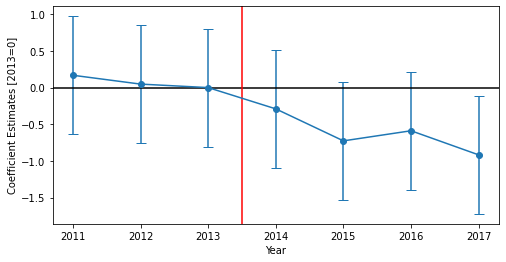

In [ ]:
# plot coefficient for each year with the confidence interval
plot_graph(year_coef_output)

In [ ]:
# perform triple difference regression, as illustrated in Equation (2)
reg_output = smf.ols(formula='log_output ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                           + is_after_reform * is_manu * is_quebec',
                 data=df_output).fit()
reg_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_output   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.684e+04
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.46e-41
Time:                        02:25:49   Log-Likelihood:                 20.188
No. Observations:                  28   AIC:                            -24.38
Df Residuals:                      20   BIC:                            -13.72
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            43.8095      0.080    545.042      0.000      43.642      43.977
is_after_reform                       0.2371      0.106      2.230      0.037       0.015       0.459
is_manu                             -31.9127      0.114   -280.744      0.000     -32.150     -31.676
is_after_reform:is_manu              -0.1538      0.150     -1.023      0.319      -0.468       0.160
is_quebec                             2.6777      0.114     23.556      0.000       2.441       2.915
is_after_reform:is_quebec             0.4853      0.150      3.228      0.004       0.172       0.799
is_manu:is_quebec                    -1.9716      0.161    -12.265      0.000      -2.307      -1.636
is_after_reform:is_manu:is_quebec    -0.4657      0.213     -2.190      0.041      -0.909      -0.022
==============================================================================
Omnibus:                        6.279   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                5.177
Skew:                          -0.571   Prob(JB):                       0.0751
Kurtosis:                       4.770   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""